In [1]:
import pandahouse
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import hashlib # Делать хеши
from scipy import stats # Статистикa
from tqdm.notebook import tqdm
%matplotlib inline

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230520'
}

In [3]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

In [4]:
df

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,26295,33,122,0.270492
4,1,18392,7,32,0.218750
...,...,...,...,...,...
20026,1,132567,45,296,0.152027
20027,1,30872,11,59,0.186441
20028,2,25383,42,127,0.330709
20029,2,139020,24,114,0.210526


## t - тест

In [5]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

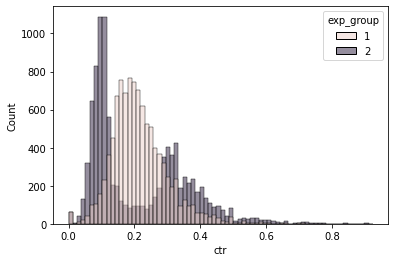

In [6]:
sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group',
              alpha=0.5,
              kde=False)
sns.set(rc={'figure.figsize':(11.7,8.27)})

## Манна - Уитни

In [7]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr, 
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

## t - тест на сглаженном CTR


In [8]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [9]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ctr'>

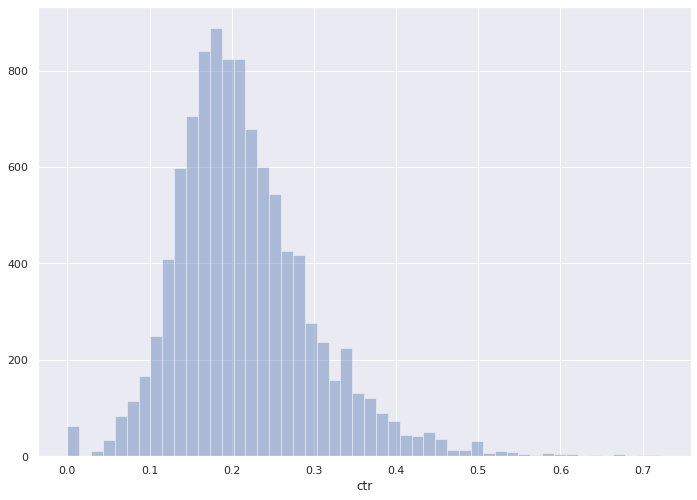

In [10]:
group1 = df[df.exp_group == 1].copy()
sns.distplot(group1.ctr, 
             kde = False)

## Распределение сглаженного CTR в 1 группе

<AxesSubplot:xlabel='smothed_ctr'>

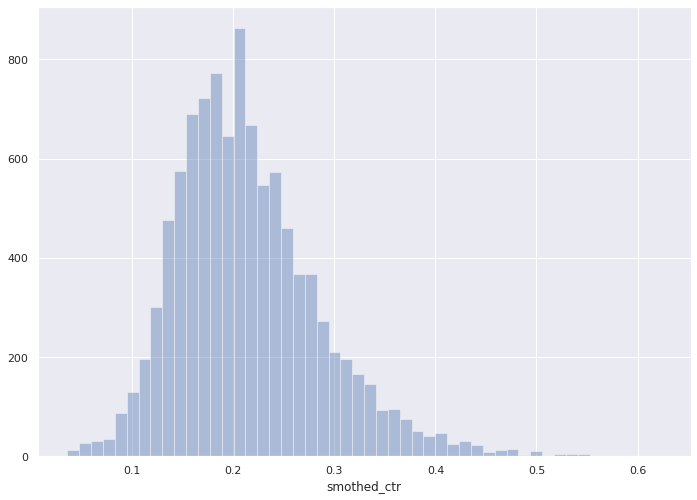

In [11]:
group1['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.distplot(group1.smothed_ctr, 
             kde = False)

<AxesSubplot:xlabel='ctr'>

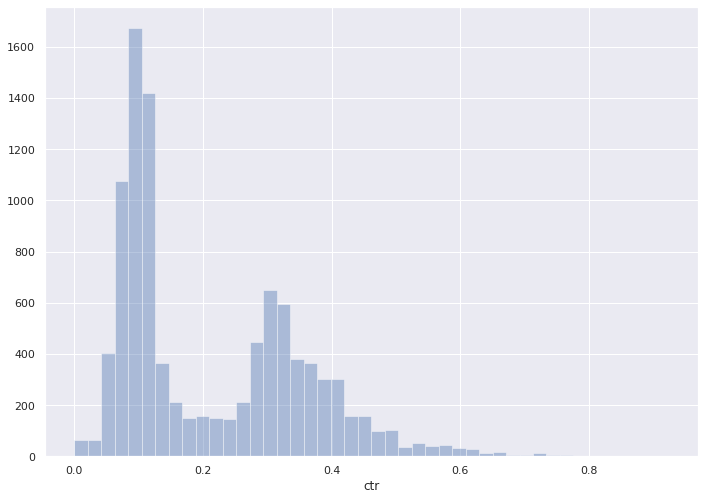

In [12]:
group2 = df[df.exp_group == 2].copy()
sns.distplot(group2.ctr, 
             kde = False)

## Распределение сглаженного CTR вo 2 группе

<AxesSubplot:xlabel='smothed_ctr'>

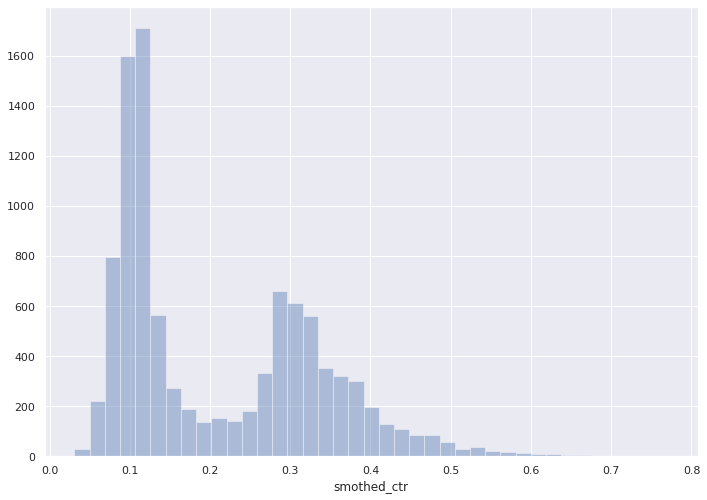

In [13]:
group2['smothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

sns.distplot(group2.smothed_ctr, 
             kde = False)

In [14]:
stats.ttest_ind(group1.smothed_ctr, 
                group2.smothed_ctr, 
                equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

## Пуассоновский бутстрап

In [15]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-01' and '2023-05-07'
    and exp_group in (1, 2)
GROUP BY exp_group, user_id
"""


df = pandahouse.read_clickhouse(q, connection=connection)

likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (2000, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (2000, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

<AxesSubplot:ylabel='Count'>

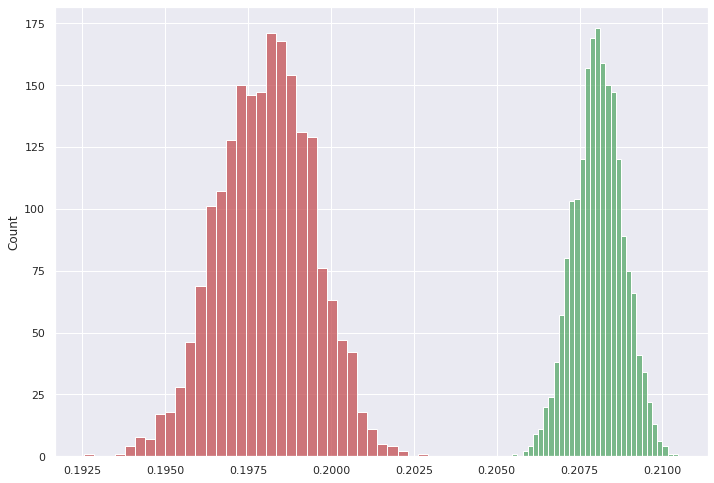

In [18]:
sns.histplot(ctr1, color = 'g')
sns.histplot(ctr2, color = 'r')

<AxesSubplot:ylabel='Count'>

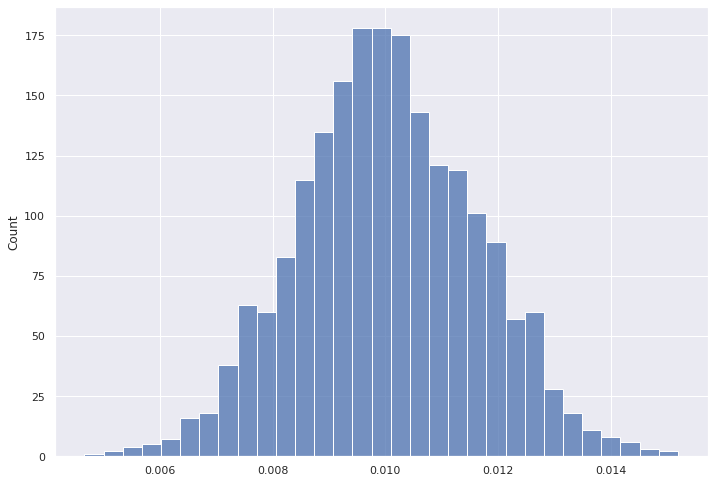

In [19]:
sns.histplot(abs(ctr2 - ctr1))

### Поскольку по распределениям CTR'а в группах очевидно видно, что они не пересекаются, то тест проводить не нужно.
### У группы 1 результат по CTR'у лучше, чем у 2

# t-тест и тест Манна - Уитни поверх бакетного преобразования

In [20]:
q = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr,
    quantileExact(0.9)(ctr) as ctr9
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-01' and '2023-05-07'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [21]:
df

,exp_group,bucket,bucket_ctr,ctr9
0,1,0,0.196481,0.307692
1,2,0,0.194262,0.384615
2,1,1,0.211887,0.318182
3,2,1,0.215328,0.467742
4,1,2,0.206271,0.322314
...,...,...,...,...
95,2,47,0.195880,0.426230
96,1,48,0.212787,0.318182
97,2,48,0.194502,0.409091
98,1,49,0.203169,0.325581


<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

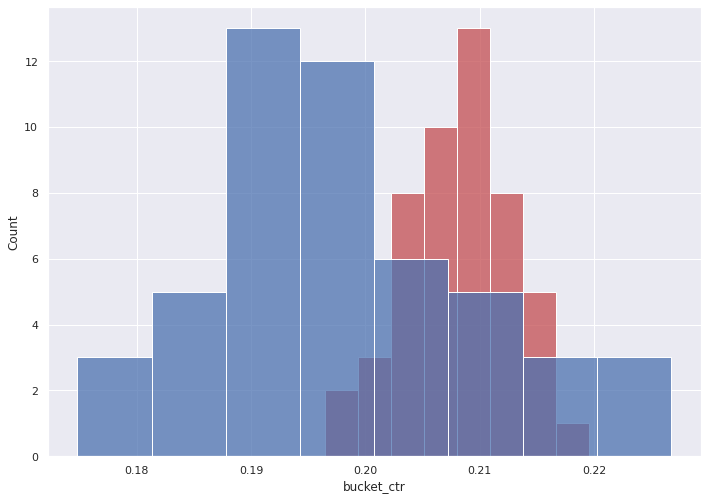

In [22]:
sns.histplot(df[df.exp_group == 1].bucket_ctr, color = 'r')
sns.histplot(df[df.exp_group == 2].bucket_ctr, color = 'b')

In [23]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

In [24]:
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var = False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

## сравниваем 90% квантили

In [25]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr9, 
                   df[df.exp_group == 2].ctr9, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=0.0, pvalue=6.344839189967265e-18)

# Вывод
## Тесты так сработали, потому что у нас получились слишком разные распределения в 2 группах. Разница видна, как визуально, так и тесты это показывают.
## Во 2 группе получилось распределение, похожее на бимодальное, вероятно новый алгоритм не совсем верно выдает посты в ленте. Может быть он не фильтрует лучшие посты для разных групп людей. 
## Считаю, что новый алгоритм не стоит раскатывать на всех пользователей, т.к. новый алгоритм показывает себя гораздо хуже при проверке тестами поверх бакетного преобразования. И с помощью бутстрапа общегрупповой CTR у 1 группы гораздо лучше.